In [1]:
from main import VoronoiFacilitySelection 
from main import dot_extract
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
from pprint import pprint


In [2]:
v, e = dot_extract()

In [18]:
#V = {"1":[0,0],"2":[2,0],"3":[0,2],"4":[2,2],"5":[1,1]}
V = {"1":np.random.rand(2)*100,"2":np.random.rand(2)*100,"3":np.random.rand(2)*100,"4":np.random.rand(2)*100,"5":np.random.rand(2)*100}
#V = {"1":np.random.rand(2)*100,"2":np.random.rand(2)*100,"3":np.random.rand(2)*100}
Z = np.random.random((10,2))*1000
model = VoronoiFacilitySelection(random_state=11,n_cells=4,ret_dia=True)
vor = Voronoi(list(V.values()))
vor = Voronoi(Z)


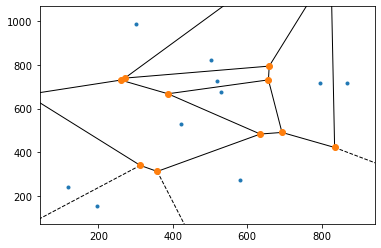

In [19]:
fig = voronoi_plot_2d(vor)

In [97]:
vor.vertices

array([[62.69499973, 40.34455974],
       [62.0778507 , 38.95164935],
       [59.07178447, 37.47995322]])

In [98]:
vor.regions

[[-1, 0], [-1, 2, 1], [-1, 0, 1], [2, -1, 0, 1], [-1, 2], []]

In [99]:
vor.point_region

array([2, 3, 1, 0, 4])

In [100]:
vor.points

array([[91.04933111, 32.13835373],
       [37.56768485, 55.83416824],
       [60.3798885 ,  9.23827528],
       [63.45972788, 69.85261145],
       [52.27889369, 10.03618992]])

In [101]:
vor.ridge_points

array([[3, 0],
       [3, 1],
       [2, 0],
       [2, 1],
       [2, 4],
       [0, 1],
       [1, 4]], dtype=int32)

In [102]:
vor.ridge_vertices

[[-1, 0], [-1, 0], [-1, 1], [1, 2], [-1, 2], [0, 1], [-1, 2]]

In [103]:
vor.ridge_dict

{(3, 0): [-1, 0],
 (3, 1): [-1, 0],
 (2, 0): [-1, 1],
 (2, 1): [1, 2],
 (2, 4): [-1, 2],
 (0, 1): [0, 1],
 (1, 4): [-1, 2]}

In [104]:
vor.point_region


array([2, 3, 1, 0, 4])

In [105]:
V

{'1': array([91.04933111, 32.13835373]),
 '2': array([37.56768485, 55.83416824]),
 '3': array([60.3798885 ,  9.23827528]),
 '4': array([63.45972788, 69.85261145]),
 '5': array([52.27889369, 10.03618992])}

In [106]:
v=list(V.values())
v

[array([91.04933111, 32.13835373]),
 array([37.56768485, 55.83416824]),
 array([60.3798885 ,  9.23827528]),
 array([63.45972788, 69.85261145]),
 array([52.27889369, 10.03618992])]

In [107]:
# this section will be pre-processing
min_x = min(np.array(list(V.values()))[:,0])
min_y = min(np.array(list(V.values()))[:,1])
max_x = max(np.array(list(V.values()))[:,0])
max_y = max(np.array(list(V.values()))[:,1])

min_bound = [min_x,min_y]
max_bound = [max_x,max_y]

# I need to find the minimum, and maximum in the point set
CH_points = np.array([min_bound,[max_bound[0],min_bound[1]],max_bound,[min_bound[0],max_bound[1]]])

CH_segments = np.array([[CH_points[i-1],CH_points[i]] for i in range(len(CH_points))])


In [108]:
# compute distances of centers, with voronoi verticies
for i, point_region in zip(range(len(vor.points)),vor.point_region):
    vor_v_i = vor.regions[point_region]
    points = np.array([vor.vertices[p] for p in vor_v_i if p >= 0])
    center = vor.points[i]
    delta = points - center
    delta_max = delta[np.argmax(np.apply_along_axis(np.linalg.norm,1,delta))]
    
    # check if delta max is bigger than any other distances found thus far for point at index i
    print(delta_max)

    

[-28.97148041   6.81329562]
[ 24.51016585 -16.88251889]
[ 1.6979622  29.71337407]
[ -0.76472815 -29.50805171]
[ 6.79289077 27.4437633 ]


In [109]:
# compute distance of centers, with C.H, points

# this section will inside the loop
neigh = NearestNeighbors(n_neighbors=1, radius=0.0000000000001) 
neigh.fit(vor.points)

Y = neigh.kneighbors(CH_points,1,return_distance=False) 

for center_i,CH_p in zip(Y,CH_points):
    center = vor.points[center_i]
    delta = CH_p-center
    
    #check if delta is greater than any other delta of center_i
    print(delta)
    

[[-14.71120885  -0.79791464]]
[[  0.         -22.90007845]]
[[27.58960323  0.        ]]
[[ 0.         14.01844321]]


In [110]:
# compute distance of centers, with edge intersections

#rotation matrix 90 deg
rot = np.array([[0,-1],[1,0]])


#compute centroid
hull = set()
for points , voronoi_ridge in vor.ridge_dict.items():
    if voronoi_ridge[np.argmin(voronoi_ridge)] < 0:
        hull.add(points[0])
        hull.add(points[1])

hull = np.array([vor.points[i] for i in hull])
centroid = np.sum(hull,axis=0)/hull.shape[0]

print('hull',hull)

for points_index, voronoi_ridge in vor.ridge_dict.items():
    # find the infnite voronoi ridges
    if voronoi_ridge[np.argmin(voronoi_ridge)] >= 0:
        continue
    print("Points Index : ",points_index,"Edge : ", voronoi_ridge)
    p0 = vor.vertices[voronoi_ridge[np.argmax(voronoi_ridge)]]
    p1 = vor.points[points_index[0]]
    p2 = vor.points[points_index[1]]
    
    #bisector
    q = (p1 + p2)/2
    # normal vector of q
    s = (p1-p2)@rot
    # q plus s
    #p_pl_s = p + s
    t1 = np.sign(np.linalg.det(np.hstack((np.array(([p1,p2,q+s])),np.ones((3,1))))))
    t2 = np.sign(np.linalg.det(np.hstack((np.array(([p1,p2,centroid])),np.ones((3,1))))))
    
    # make sure the the edge is pointing outwards from the convex hull
    if t1 == t2:
        s = -s
        
    #original math proof from :
    #https://stackoverflow.com/questions/563198/how-do-you-detect-where-two-line-segments-intersect/565282#565282
    #
    #take the idea of line segment intersection
    # q+ s   p + r
    # \    /
    #  \  /
    #   \/
    #   /\
    #  /  \
    # /    \
    # p     q
    #
    # p + t*r = q + u*s ; where t and u are scalars
    # (p + t*r)xs = (q + u*s)xs
    # pxs + t*rxs = qxs + 0
    # t*rxs = qxs - pxs
    # t = [(q-p)xs]/rxs
    # if t is negaive, then we went left of p, thus did not intersect
    # if |p + tr - p| > |p + r - p| then we have gone past our endpoint c2
    # note, this is also t|r| > |r| -> t > 1
    
    #print('p+s',p+s)
    #print('p',p)
    #print("calculating t")
    for c1, c2 in CH_segments:
        p = c1
        r = c2 - c1

        t = np.cross((q-p),s)/np.cross(r,s)
        u = np.cross((q-p),r)/np.cross(r,s)
        

        # ray q intersects segment p at point p + tr (u cannot b zero, else we go backards, t must be btwn segment)
        if 0 <= t and t <= 1 and u >= 0 and np.cross(r,s) != 0:
            
            #print('p = ',p, ' r = ',r,' p + r = ', p + r)
            #print('q = ',q, ' s = ',s, ' q + s = ', q + s)
            
            #print('r',r)
            #print('s',s)
            #print('cross-product r x s: ',cross)
            #print('q-p',q-p)
            #print('r',r)
            #print('cross-product (q - p) x r',np.cross((q-p),r))
            #print('t',t)
            print('p+t*r',p + t*r)
            #print('u',u)
        
        #print("-----------------")

    


hull [[91.04933111 32.13835373]
 [37.56768485 55.83416824]
 [60.3798885   9.23827528]
 [63.45972788 69.85261145]
 [52.27889369 10.03618992]]
Points Index :  (3, 0) Edge :  [-1, 0]
p+t*r [91.04933111 61.08697387]
Points Index :  (3, 1) Edge :  [-1, 0]
p+t*r [46.71878084 69.85261145]
Points Index :  (2, 0) Edge :  [-1, 1]
p+t*r [84.26405753  9.23827528]
Points Index :  (2, 4) Edge :  [-1, 2]
p+t*r [56.29009544  9.23827528]
Points Index :  (1, 4) Edge :  [-1, 2]
p+t*r [37.56768485 30.57241468]


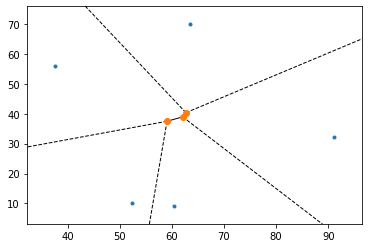

In [111]:
fig = voronoi_plot_2d(vor)

In [112]:
vor.vertices

array([[62.69499973, 40.34455974],
       [62.0778507 , 38.95164935],
       [59.07178447, 37.47995322]])

In [113]:
vor.regions

[[-1, 0], [-1, 2, 1], [-1, 0, 1], [2, -1, 0, 1], [-1, 2], []]

In [114]:
vor.points

array([[91.04933111, 32.13835373],
       [37.56768485, 55.83416824],
       [60.3798885 ,  9.23827528],
       [63.45972788, 69.85261145],
       [52.27889369, 10.03618992]])

In [115]:
vor.point_region

array([2, 3, 1, 0, 4])

In [116]:


hull = set()
for points , voronoi_ridge in vor.ridge_dict.items():
    if voronoi_ridge[np.argmin(voronoi_ridge)] < 0:
        hull.add(points[0])
        hull.add(points[1])

hull = np.array([vor.points[i] for i in hull])
centroid = np.sum(hull,axis=0)/hull.shape[0]


In [150]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from shapely.geometry import Point, Polygon
from main import voronoi_endpoint_intersection

# compute distance of centers, with edge intersections

#rotation matrix 90 deg
rot = np.array([[0,-1],[1,0]])


#compute centroid
hull = set()
for points , voronoi_ridge in vor.ridge_dict.items():
    if voronoi_ridge[np.argmin(voronoi_ridge)] >= 0:
        hull.add(points[0])
        hull.add(points[1])

hull = np.array([vor.points[i] for i in hull])
centroid = np.sum(hull,axis=0)/hull.shape[0]

# map voronoi point index to points indicies between edge 
map_vertex_points = {}
for points_index, voronoi_ridge in vor.ridge_dict.items():

    if voronoi_ridge[np.argmin(voronoi_ridge)] >= 0:
        continue
    p0 = vor.vertices[voronoi_ridge[np.argmax(voronoi_ridge)]]
    map_vertex_points[voronoi_ridge[np.argmax(voronoi_ridge)]] = list(points_index)

print(map_vertex_points)







region = []

for region_index, vor_verticies in zip(range(len(vor.regions)),vor.regions):
    points = [vor.vertices[v].tolist() for v in vor_verticies if v >= 0]
    if len(points) == 0:
        region.append([])
        continue
    if not -1 in vor_verticies:
        region.append(points)
        continue
        
    

    
    end_points = [v for v in vor_verticies if not map_vertex_points.get(v,None) is None]
    for end_point in end_points:
        p1 = vor.points[map_vertex_points[end_point][0]] # points forming bisector
        p2 = vor.points[map_vertex_points[end_point][1]] # points forming bisector
    
        centroid = centroid # point inside convex polygon
        CH_segments = CH_segments # intersecting segments
        
        
        
        for edge in CH_segments:
            i = voronoi_endpoint_intersection(p1,p2,centroid,edge)
            if i is None:
                continue
            print(i)
            if not i.tolist() in points:
                points.append(i.tolist())
    
    
    Y = neigh.kneighbors(CH_points,1,return_distance=False)
    
    for point_index,point_i in zip(range(len(Y)),Y):
        if region_index == vor.point_region[point_i[0]]:
            points.append(vor.points[point_i[0]].tolist())
    
    region.append(points)
    
    

    
# convert to convex hull, and find a ordering or verticies to form polygon
#----------------
polygons = list()

print("computing CH")

for s in region:
    if len(s) == 0:
        polygons.append(s)
        continue
    h = ConvexHull(s)
    pprint(h.vertices)
    print(len(h.vertices))
    z = list()
    z = Polygon([h.points[h.vertices[i-1]] for i in range(h.vertices.shape[0]+1)])
    polygons.append(z)
    
pprint(polygons)
pprint(len(polygons))


{0: [3, 1], 1: [2, 0], 2: [1, 4]}
[46.71878084 69.85261145]
[37.56768485 30.57241468]
[84.26405753  9.23827528]
[46.71878084 69.85261145]
[84.26405753  9.23827528]
[37.56768485 30.57241468]
[46.71878084 69.85261145]
[84.26405753  9.23827528]
[37.56768485 30.57241468]
computing CH
array([2, 1, 0], dtype=int32)
3
array([2, 3, 1], dtype=int32)
3
array([4, 2, 1, 3], dtype=int32)
4
array([3, 5, 4, 6], dtype=int32)
4
array([0, 1, 2], dtype=int32)
3
 []]
6


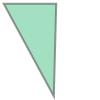

In [151]:
Polygon(polygons[0])

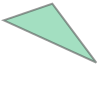

In [152]:
Polygon(polygons[1])

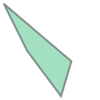

In [153]:
Polygon(polygons[2])

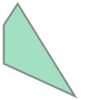

In [154]:
Polygon(polygons[3])

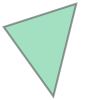

In [155]:
Polygon(polygons[4])

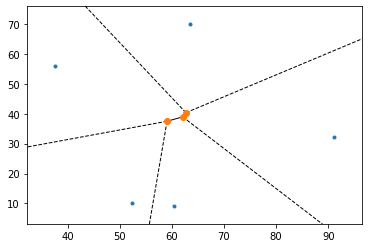

In [125]:
fig = voronoi_plot_2d(vor)

In [29]:
for points_index, voronoi_ridge in vor.ridge_dict.items():
    # find the infnite voronoi ridges
    if voronoi_ridge[np.argmin(voronoi_ridge)] >= 0:
        continue
    print("Points Index : ",points_index,"Edge : ", voronoi_ridge)
    p0 = vor.vertices[voronoi_ridge[np.argmax(voronoi_ridge)]]
    p1 = vor.points[points_index[0]]
    p2 = vor.points[points_index[1]]
    
    #bisector
    q = (p1 + p2)/2
    # normal vector of q
    s = (p1-p2)@rot
    # q plus s
    #p_pl_s = p + s
    t1 = np.sign(np.linalg.det(np.hstack((np.array(([p1,p2,q+s])),np.ones((3,1))))))
    t2 = np.sign(np.linalg.det(np.hstack((np.array(([p1,p2,centroid])),np.ones((3,1))))))
    
    # make sure the the edge is pointing outwards from the convex hull
    if t1 == t2:
        s = -s
        
    #original math proof from :
    #https://stackoverflow.com/questions/563198/how-do-you-detect-where-two-line-segments-intersect/565282#565282
    #
    #take the idea of line segment intersection
    # q+ s   p + r
    # \    /
    #  \  /
    #   \/
    #   /\
    #  /  \
    # /    \
    # p     q
    #
    # p + t*r = q + u*s ; where t and u are scalars
    # (p + t*r)xs = (q + u*s)xs
    # pxs + t*rxs = qxs + 0
    # t*rxs = qxs - pxs
    # t = [(q-p)xs]/rxs
    # if t is negaive, then we went left of p, thus did not intersect
    # if |p + tr - p| > |p + r - p| then we have gone past our endpoint c2
    # note, this is also t|r| > |r| -> t > 1
    

    for c1, c2 in CH_segments:
        p = c1
        r = c2 - c1

        t = np.cross((q-p),s)/np.cross(r,s)
        u = np.cross((q-p),r)/np.cross(r,s)
        

        # ray q intersects segment p at point p + tr (u cannot b zero, else we go backards, t must be btwn segment)
        if 0 <= t and t <= 1 and u >= 0 and np.cross(r,s) != 0:

            print('p+t*r',p + t*r)


Points Index :  (2, 3) Edge :  [-1, 2]
p+t*r [1. 2.]
Points Index :  (2, 0) Edge :  [-1, 0]
p+t*r [0. 1.]
Points Index :  (0, 1) Edge :  [-1, 1]
p+t*r [1. 0.]
Points Index :  (1, 3) Edge :  [-1, 3]
p+t*r [2. 1.]


<ipython-input-29-8d7d9180ac2b>:50: RuntimeWarning: divide by zero encountered in true_divide
  t = np.cross((q-p),s)/np.cross(r,s)
<ipython-input-29-8d7d9180ac2b>:51: RuntimeWarning: divide by zero encountered in true_divide
  u = np.cross((q-p),r)/np.cross(r,s)


[[[62.69499973242412, 40.344559735737505],
  [46.7187808417022, 69.85261144524809],
  [63.459727883147195, 69.85261144524809]],
 [[59.071784466530865, 37.479953222875125],
  [62.077850701499614, 38.95164934844756],
  [37.56768484820782, 30.57241467716957],
  [84.26405753348229, 9.238275279599584]],
 [[62.69499973242412, 40.344559735737505],
  [62.077850701499614, 38.95164934844756],
  [46.7187808417022, 69.85261144524809],
  [84.26405753348229, 9.238275279599584],
  [91.04933110941303, 32.13835373055088]],
 [[59.071784466530865, 37.479953222875125],
  [62.69499973242412, 40.344559735737505],
  [62.077850701499614, 38.95164934844756],
  [37.56768484820782, 30.57241467716957],
  [46.7187808417022, 69.85261144524809],
  [84.26405753348229, 9.238275279599584],
  [37.56768484820782, 55.83416823773331]],
 [[59.071784466530865, 37.479953222875125],
  [37.56768484820782, 30.57241467716957],
  [52.278893694557425, 10.036189921052884]],
 []]


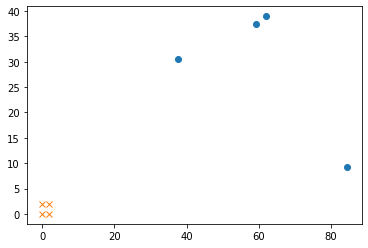

In [123]:
j = 1
xval = [i[0] for i in region[j]]
yval = [i[1] for i in region[j]]
plt.plot(xval,yval,'o')
plt.plot([0,0,2,2],[0,2,0,2],'x')

pprint(region)